# This notebook is part of the Coursera capstone project on accident prevention

### Table of contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Business understanding</a></li>
        <li><a href="#ref2">Data understanding</a></li>
        <li><a href="#ref3">Data preparation</a></li>
        <li><a href="#ref3">Modelling</a></li>
        <li><a href="#ref3">Evaluation</a></li>
    </ol>
</div>
<br>

## Importing libraries

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pandas import DataFrame
%matplotlib inline

<a id="ref1"></a>

# Business understanding

## Background

Every year the lives of approximately 1.35 million people are cut short as a result of a road traffic crash. Between 20 and 50 million more people suffer non-fatal injuries, with many incurring a disability as a result of their injury.

Road traffic injuries cause considerable economic losses to individuals, their families, and to nations as a whole. These losses arise from the cost of treatment as well as lost productivity for those killed or disabled by their injuries, and for family members who need to take time off work or school to care for the injured. Road traffic crashes cost most countries 3% of their gross domestic product. More than half of all road traffic deaths are among vulnerable road users: pedestrians, cyclists, and motorcyclists. Road traffic injuries are the leading cause of death for children and young adults aged 5-29 years.

Source: https://www.who.int/news-room/fact-sheets/detail/road-traffic-injuries#:~:text=Approximately%201.35%20million%20people%20die,of%20their%20gross%20domestic%20product.


## Problem

### The dataset from SDOT available to us, tells us the following details:
#### Details of accident

1. Severity of collisions: Tells us about the extent of damage - property damage, injury or fatality

2. Collision type - We understand whether the collision was head on, whether pedestrians or cyclists were involved and similar data

3. We also also analyse time of accident date and time: This reveals whether more accidents occur on weekdays or weekends and whether accidents occur more at night

#### Affected

1. No. of persons involved - Reveals whether only one person hit a non mobilized object or more people were involved
2. No. of cyclists involved in accidents were cyclists were involved
3. No. of pedestrians affected by different accidents
4. No. of vehicles involved in accidents
5. If an accident involved pedestrians, whether they were granted their way
6. No. of accidents where parked cars were hit

#### Location factors

1. Type of address: Whether more accidents occur in alleys, blocks or intersections
3. In which junction types more accidents occur

#### Human factors

1. He/she was attentive/ unattentive
2. If the person was under influence
3. If the person was speeding

#### Environmental factors

1. If rainy days cause more accidents or sunny days
2. Whether dry or wet roads cause more accidents
3. If lighting conditions are a factor in accidents

#### The aim is to understand the causes of road accidents by analysing the parameters outlined above, namely:
1. Location factors
2. Human factors
3. Environmental factors

## Client

Road traffic crashes cost most countries 3% of their gross domestic product. Governments would be interested to understand the reasons behind road accidents. The aim of this project is to equip them with data driven insights to enable decision making to reduce the number of accidents.

<a id="ref2"></a>
# Data understanding

### Loading the dataset

In [10]:
df = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv")
print("No. of (rows, columns) = ", df.shape )
pd.set_option('display.max_columns', None)

No. of (rows, columns) =  (194673, 38)


In [11]:
k = df.isnull().sum()
k.sort_values(ascending=False, inplace=True)
k = k.to_frame()
k = k.reset_index()
k = k[k[0]!=0]
k.columns = ['Attribute', 'Count of missing data']

We need to plug in missing data in the dataset

In [12]:
#0. PEDROWNOTGRNT only Y has been entered. Assuming other values to be N
df['PEDROWNOTGRNT'].fillna("N", inplace=True) 
#1. EXCEPTRSNDESC has unimportant data and we will drop this column
#2. SPEEDING only Y has been entered. Assuming other values to be N
df['SPEEDING'].fillna("N", inplace=True)
#3. INATTENTIONIND only Y has been entered. Assuming other values to be N
df['INATTENTIONIND'].fillna("N", inplace=True)
#4. INTKEY only applicable when ADDRTYPE = Intersection
df['INTKEY'].fillna(0, inplace=True)
#5. EXCEPTRSNCODE has unimportant data and we will drop this column
#6. SDOTCOLUMN is not required and we will drop it 

#16. LOCATION - cannot sustitute missing data, filling 0 for the unknown values
df['LOCATION'].fillna(0, inplace=True)

#17. ADDRTYPE, filling 0 for the unknown values
df['UNDERINFL'].fillna('0', inplace=True)

#18. ST_COLCODE, filling 0 for the unknown values
df['ST_COLCODE'].fillna(0, inplace=True)

#df.replace(np.nan, '0', inplace=True)
df.isnull().sum()

df['PEDROWNOTGRNT'].astype('str')
df['HITPARKEDCAR'].astype('str')
df['UNDERINFL'].astype('str')
df['SPEEDING'].astype('str')

df['PEDROWNOTGRNT'].replace('N','0', inplace=True)
df['PEDROWNOTGRNT'].replace('Y','1', inplace=True)
df['HITPARKEDCAR'].replace('N','0', inplace=True)
df['HITPARKEDCAR'].replace('Y','1', inplace=True)
df['UNDERINFL'].replace('N','0', inplace=True)
df['UNDERINFL'].replace('Y','1', inplace=True)
df['SPEEDING'].replace('N','0', inplace=True)
df['SPEEDING'].replace('Y','1', inplace=True)

df['UNDERINFL'] = df['UNDERINFL'].astype('int64')
df['SPEEDING'] = df['SPEEDING'].astype('int64')
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].astype('int64')
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].astype('int64')

We will deal with the remaining Nan values in the dataset later

### Now let us look for patterns in the data

Text(0.5, 1.0, 'Percentage of collisions')

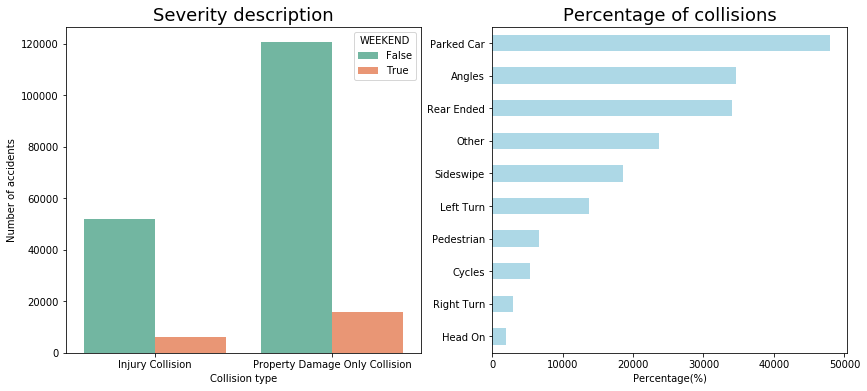

In [13]:
df['DAY'] = pd.to_datetime(df['INCDATE']).dt.dayofweek
df['WEEKEND'] = df['DAY'] > 5 
df['WEEKEND'].rename({'False':'Weekday', 'True':'Weekend'}, inplace=True)

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.countplot(x="SEVERITYDESC",hue="WEEKEND", data=df, palette="Set2")
plt.title('Severity description', fontsize=18)
plt.xlabel("Collision type")
plt.ylabel("Number of accidents")

plt.subplot(1,2,2)
df['COLLISIONTYPE'].value_counts(ascending=True).plot.barh(color='lightblue')
plt.xlabel("Percentage(%)")
plt.title("Percentage of collisions", fontsize=18)

Observations:
1. More accidents occur on weekdays
2. Maximum accidents occur when a parked car is hit

### Analyzing location factors

Text(0.5, 0, 'Address type')

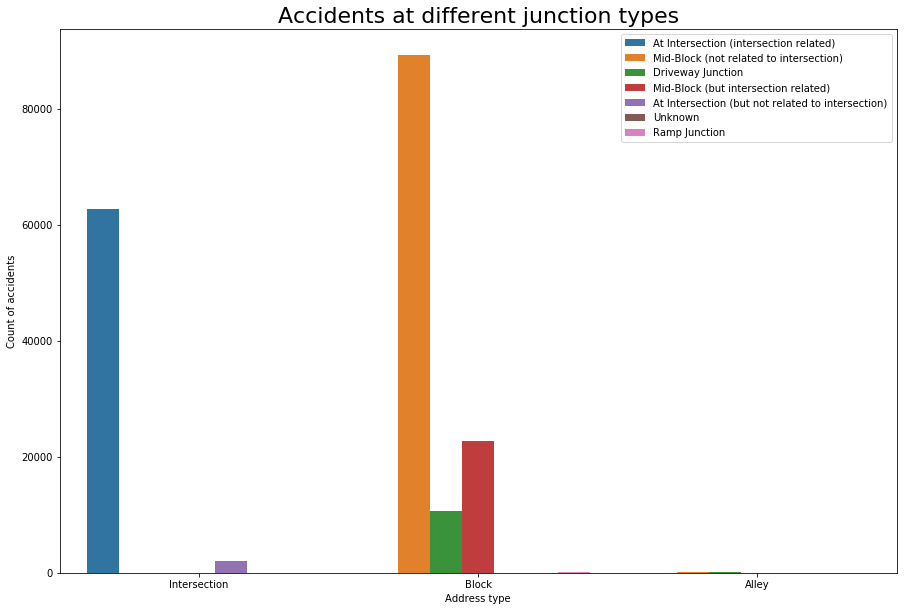

In [14]:
plt.figure(figsize=(15,10))
sns.countplot(x="ADDRTYPE", hue="JUNCTIONTYPE", data=df )
plt.title("Accidents at different junction types", fontsize=22)
plt.legend(loc="upper right")
plt.ylabel("Count of accidents")
plt.xlabel("Address type")

Observations:
    1. Some accidents unrelated to accidents occur at intersections.
    2. In blocks, maximum accidents occur at midblock and away from intersections.
    3. very few accidents occur at alleys.

### Analysing human factors

Text(0.5, 0, 'Whether drivers were inattentive')

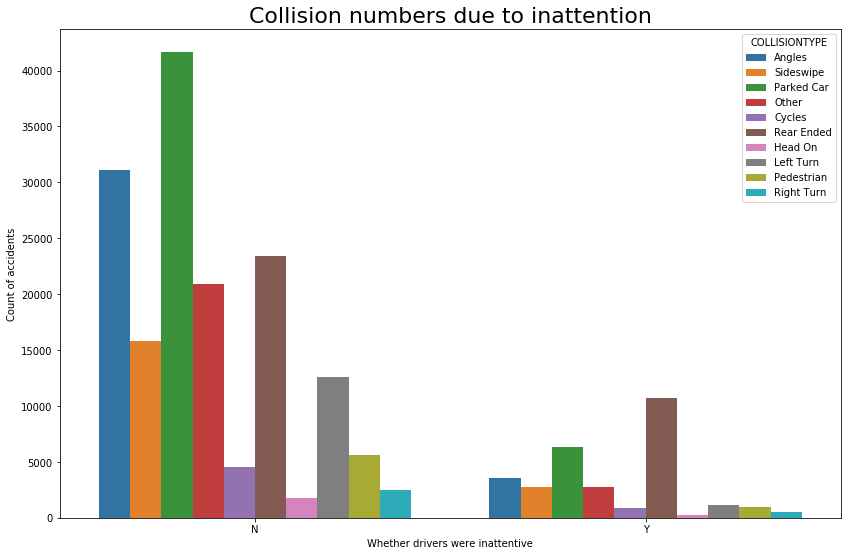

In [15]:
plt.figure(figsize=(14,9))
sns.countplot(x="INATTENTIONIND", hue="COLLISIONTYPE", data=df)
plt.title("Collision numbers due to inattention", fontsize=22)
plt.ylabel("Count of accidents")
plt.xlabel("Whether drivers were inattentive")

Maximum accidents occured when drivers were attentive. 

Text(0.5, 0, 'Whether drivers were under influence')

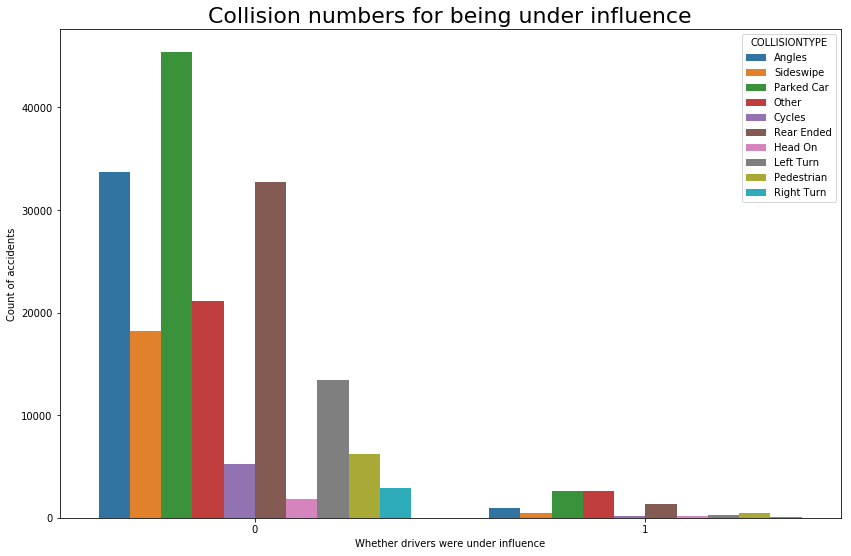

In [16]:
plt.figure(figsize=(14,9))
sns.countplot(x="UNDERINFL", hue="COLLISIONTYPE", data=df)
plt.title("Collision numbers for being under influence", fontsize=22)
plt.ylabel("Count of accidents")
plt.xlabel("Whether drivers were under influence")

Maximum accidents occured when drivers were not under influence. 

### Analysing environmental factors

Text(0.5, 0, 'Percentage of accidents(%)')

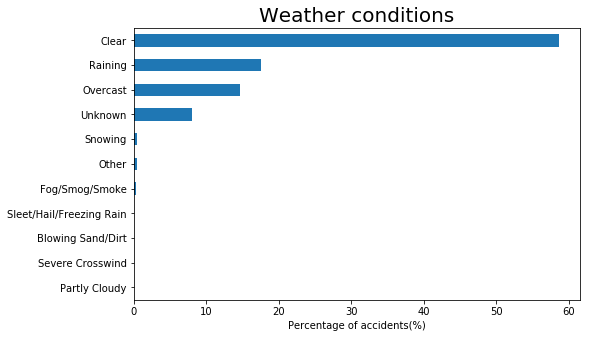

In [17]:
plt.figure(figsize=(8,5))
ax0 = df['WEATHER'].value_counts( ascending=True, normalize=True).mul(100).plot.barh()
plt.title("Weather conditions", fontsize=20)
plt.xlabel("Percentage of accidents(%)")

From the above graph, we can conclude that weather is not a strong factor for predicting accidents

Text(0.5, 0, 'Percentage of accidents(%)')

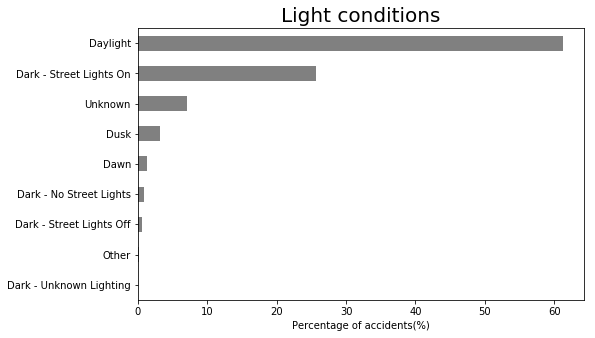

In [18]:
plt.figure(figsize=(8,5))
ax1 = df['LIGHTCOND'].value_counts( ascending=True, normalize=True).mul(100).plot.barh(color='grey')
plt.title("Light conditions", fontsize=20)
plt.xlabel("Percentage of accidents(%)")

From the above graph, we can conclude that lighting conditions is not a strong factor for predicting accidents

Text(0.5, 0, 'Percentage of accidents(%)')

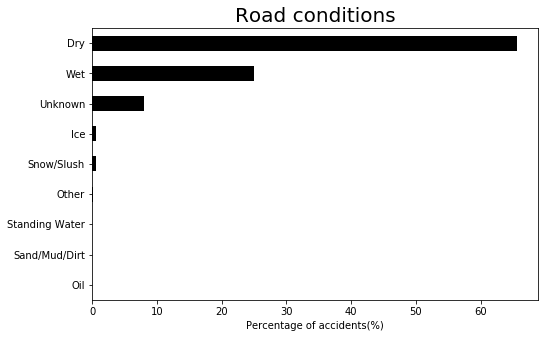

In [19]:
plt.figure(figsize=(8,5))
ax2 = df['ROADCOND'].value_counts( ascending=True, normalize=True).mul(100).plot.barh(color='black')
plt.title("Road conditions", fontsize=20)
plt.xlabel("Percentage of accidents(%)")

From the above graph, we can conclude that road condition is not a strong factor for predicting accidents

# Week 3 assignment begins here

#drop description columns
df_feat = df.drop(['OBJECTID','SEVERITYDESC','INCDATE' ,'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'SDOTCOLNUM', 'SDOT_COLDESC','ST_COLDESC', 'DAY', 'INTKEY',  'EXCEPTRSNCODE', 'EXCEPTRSNDESC','X','Y','SEVERITYCODE.1'],axis=1)

#Splitting ADDRTYPE to Alley, block and intersection
df_feat[['Alley', 'Block', 'Intersection']] = pd.get_dummies(df_feat['ADDRTYPE'])
df_feat.drop(['ADDRTYPE'], axis=1, inplace=True)

#Splitting COLLISIONTYPE
df_feat[pd.get_dummies(df_feat['COLLISIONTYPE']).columns] = pd.get_dummies(df_feat['COLLISIONTYPE'])
df_feat.drop(['COLLISIONTYPE'], axis=1, inplace=True)

#Splitting JUNCTIONTYPE
df_feat[pd.get_dummies(df_feat['JUNCTIONTYPE']).columns] = pd.get_dummies(df_feat['JUNCTIONTYPE'])
df_feat.drop(['JUNCTIONTYPE'], axis=1, inplace=True)

#Splitting WEATHER
df_feat[pd.get_dummies(df_feat['WEATHER']).columns] = pd.get_dummies(df_feat['WEATHER'])
df_feat.drop(['WEATHER'], axis=1, inplace=True)

#Splitting ROADCOND
df_feat[pd.get_dummies(df_feat['ROADCOND']).columns] = pd.get_dummies(df_feat['ROADCOND'])
df_feat.drop(['ROADCOND'], axis=1, inplace=True)

#Splitting LIGHTCOND
df_feat[pd.get_dummies(df_feat['LIGHTCOND']).columns] = pd.get_dummies(df_feat['LIGHTCOND'])
df_feat.drop(['LIGHTCOND'], axis=1, inplace=True)

df_feat['INATTENTIONIND'] = df_feat['INATTENTIONIND'].map({'Y': 1, 'N': 0})
df_feat['UNDERINFL'] = df_feat['UNDERINFL'].map({'Y': 1, 'N': 0, 'nan': 0})
df_feat['SPEEDING'] = df_feat['SPEEDING'].map({'Y': 1, 'N': 0})
df_feat['PEDROWNOTGRNT'] = df_feat['PEDROWNOTGRNT'].map({'Y': 1, 'N': 0})
df_feat['HITPARKEDCAR'] = df_feat['HITPARKEDCAR'].map({'Y': 1, 'N': 0})
df_feat['WEEKEND']  = df_feat['WEEKEND'].astype('int') 

df_feat['UNDERINFL'].unique()
df_feat.corr()

### Description of attributes:

| Attribute | Description|Use-case|          
|-----------|------------|-----|
|OBJECTID| ESRI unique identifier|ID|
|Shape|ESRI geometry field |GEO|
|INCKEY|A unique key for the incident|ID|
|COLDETKEY|Secondary key for the incident|ID|
|ADDRTYPE |Alley/block/intersection|GEO, Feature|
|INTKEY|Key that corresponds to the intersection associated with a collision |GEO|
|LOCATION|Description of the general location of the collision |GEO, Feature|
|EXCEPTRSNCODE|||
|EXCEPTRSNDESC|||
|SEVERITYCODE|3—fatality, 2b—serious injury, 2—injury, 1—prop damage, 0—unknown|Outcome|
|SEVERITYDESC|A detailed description of the severity of thecollision |Outcome|
|COLLISIONTYPE|Collision type |Feature|
|PERSONCOUNT|The total number of people involved in thecollision |Feature|
|PEDCOUNT|The number of pedestrians involved in the collision.  |Feature|
|PEDCYLCOUNT |The number of bicycles involved in the collision.  |Feature|
|VEHCOUNT|The number of vehicles involved in the collision.|Feature|
|INJURIES|The number of total injuries in the collision.|Feature|
|SERIOUSINJURIES|The number of serious injuries in the collision. |Feature|
|FATALITIES|The number of fatalities in the collision.|Feature|
|INCDATE|The date of the incident. |Feature|
|INCDTTM|The date and time of the incident|Feature|
|JUNCTIONTYPE|Category of junction at which collision tookplace |Feature|
|SDOT_COLCODE| A code given to the collision by SDOT. |Feature|
|SDOT_COLDESC|A description of the collision corresponding to the collision code. |Feature|
|INATTENTIONIND| Whether or not collision was due to inattention. (Y/N) |Feature|
|UNDERINFL|Whether or not a driver involved was under the influence of drugs or alcohol. |Feature|
|WEATHER|A description of the weather conditions during the time of the collision. |Feature|
|ROADCOND|The condition of the road during the collision. |Feature|
|LIGHTCOND|The light conditions during the collision.|Feature|
|PEDROWNOTGRNT|Whether or not the pedestrian right of way was not granted. (Y/N) |Feature|
|SDOTCOLNUM|A number given to the collision by SDOT. |ID|
|SPEEDING|Whether or not speeding was a factor in the collision. (Y/N) |Feature|
|ST_COLCODE|A code provided by the state that describes the collision. |Feature|
|ST_COLDESC|A description that corresponds to the state’s coding designation.|Feature|
|SEGLANEKEY|A key for the lane segment in which the collision occurred. |Feature|
|CROSSWALKKEY|A key for the crosswalk at which the collision occurred. |Feature|
|HITPARKEDCAR|Whether or not the collision involved hitting aparked car. (Y/N) |Feature|